# Material Balances XI

This lecture departs slightly from the approaches we have used so far. It introduces an older method of reactor sizing based on the use of Levenspiel Plots. These techniques are not as widely used since numerical methods became so easily accessible to everyone, but they are very useful for building insights about sizing and sequencing flow reactors. We should view this section as complementary to the work we have already done with material balances.

In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from math import ceil, floor

## Levenspiel Plots

We will now take a small break from the usual material balance problems and solutions, and we will instead consider a primarily graphical approach to reactor sizing. The tool we will discuss in this Notebook is the Levenspiel Plot, which is named after [Prof. Octave Levenspiel](https://en.wikipedia.org/wiki/Octave_Levenspiel), who was a professor at Oregon State and pioneer of Chemical Reaction Engineering. He wrote one of the most popular and influential reaction engineering textbooks of all time, and he is responsible for shaping the approaches that we still use for modelling and analysis of chemical reactors. The Levenspiel Plot is an old method that is probably no longer extensively used for reactor sizing, but it helps us to build useful insights about how reactor size (or time required inside of the reactor) scales with reaction rate. This method will also help us to visualize and understand the differences between PFR and CSTR reactor sizes that are required to achieve the exact same conversion level for a given reaction. We will also use these to help to visualize optimal strategies for reactor sequencing when our process involves more than one reactor (and sometimes more than one type of reactor). We will only consider CSTRs and PFRs using Levenspiel Plots, but the concepts are general. Levenspiel Plots will comprise the focus of this Notebook as well as the next one, [Notebook 26](https://jqbond.github.io/CEN587/Notebooks/587-N26.html)

Let's start by establish some basic rules and parameters that will apply throughout our discussion. First, we will consider a single, irreversible reaction involving two species:

$$A \longrightarrow B$$

Second, we will assume that the rate of this reaction depends only the concentration of species $A$, that is to say $r = f(C_A)$. More specifically, we will specify that $r \neq f(C_B)$. We have not specified that dependence yet, but with this in mind, we can say generally that:

$$r = k{C_A}^\alpha$$

Throughout this notebook and the next one, we will specify that ***our flow reactors always operate at steady state and that the density of the fluid in the reactor is constant*** and does not change between the reactor inlet and the reactor outlet. As we have covered extensively, for a flow reactor a steady state, constant density means that the volumetric flowrate is constant between the reactor inlet and reactor outlet, so for all of our Levenspiel Plot analysis, we can say $Q = Q_f$.

Before we specify a reaction order, we will consider some general concepts abour reactor sizing first.

### A generic CSTR Balance

If we write a balance on species $A$ for a CSTR operating at steady state, we get:

$$0 = F_{A,f} - F_A + R_AV$$

We really want to consider the size of the reactor in this analysis, so we'll solve this balance for Volume:

$$V = \frac{-(F_{A,f} - F_A)}{R_A}$$

For this simple reaction, we know that:

$$R_A = -r$$

We recognize that the rate of reaction will *generally* depend on the fractional conversion of reactant (as $X_A$ increases, $C_A$ decreases), so let's write the reaction rate so that it makes clear that $r$ and by extention $R_A$ are function of $X_A$:

$$R_A = -r \, (X_A)$$

We also can derive the following result from the definition of fractional conversion of $A$ in a flow reactor:

$$F_{A,f} - F_A = F_{A,f}X_A$$

Substituting these two results into the expression for Volume, we find:

$$V = \frac{F_{A,f}X_A}{r \, (X_A)}$$

```{tip}
We can gain tremendous insight from considering this equation! The numerator of this expression conceptually represents the extensive change in the quantity of species $A$ per unit time $(\mathrm{mol \ time^{-1}})$. The denominator represents the intensive rate of generation/consumption in units of $(\mathrm{mol \ time^{-1} \ volume^{-1}})$. If we divide the quantity of species being consumed per time by the rate at which they are consumed per unit volume, we get the size of the system. In other words, the size of the reactor is determined by the amount of reaction (conversion) it achieves divided by the rate at which it achieves the reaction.
```

### A Generic PFR Balance

We start by writing a balance on $A$ in a PFR at steady state:

$$\frac{dF_A}{dV} = R_A$$

We express the Flowrate of $A$ as a function of conversion:

$$F_A = F_{A,f} - F_{A,f}X_A = F_{A,f} (1 - X_A)$$

And we know from the CSTR balance above that:

$$R_A = -r \, (X_A)$$

Where, again, the $r \, (X_A)$ term indicates explicitly that rate is a function of fractional conversion of $A$.  Making these substitutions into the material balance, we get

$$\frac{dX_A}{dV} = \frac{r \, (X_A)}{F_{A,f}}$$

This equation can be rearranged as shown below:

$$dV = \frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

If you compare this to the result obtained for CSTR volume, you will see that this is actually a differential analog of the CSTR balance.

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

```{tip}
The insight we discussed above about CSTR sizing still applies for a PFR! In a PFR, the balance essentially tells us that the differential change in volume $(dV)$ is equal to the differential quantity of species $A$ converted divided by the intensive rate at which it is converted. 
```

If we want to solve for the total PFR volume to compare to the total CSTR volume, we have to integrate the PFR balance:

$$\int_0^{V_\textrm{PFR}}dV = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

The left hand side is easy to integrate, and we get the result that:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

Again, loosely, the size of the PFR depends on the quantity of species that we are converting divided by the rate at which we convert them.

### Main Ideas

What we see from these equations is that the size of the reactor (whether it is a PFR or a CSTR) scales directly with the quantity of "stuff" converted in that reactor, and it scales inversely with the rate of reaction. In other words, the more "stuff" the reactor needs to convert, the larger it needs to be (with everything else fixed). Analogously, the faster the reaction occurs (larger r), the smaller the reactor needs to be (with everything else fixed). So these are the two big picture things we need to think about when we consider reactor sizes and especially when we compare the performance of CSTRs and PFRs: (1) how much extensive conversion does the reactor need to accomplish and (2) how quickly does the reaction occur inside of that reactor. The differences between CSTRs and PFRs will depend on the reaction rate, specificially how the reaction rate changes as a function of fractional conversion.  Until we know that relationship, we can't really compare the sizes of these two reactors.

## A general rate of reaction

For this irreversible reaction involving two species:

$$A \longrightarrow B$$

We can propose that the rate of reaction scales with the concentration of $A$ in some unknown power law relationship:

$$r = k{C_A}^\alpha$$

Here $\alpha$ is an unspecified reaction order (0, 1, -3, 0.5, etc.).  We can express the concentration of $A$ as a function of fractional conversion of $A$ using molar and volumetric flowrates:

$$C_A = \frac{F_A}{Q}$$

For a constant density flow reactor, $Q = Q_f$ (we have stated that assumption applies already):

$$C_A = \frac{F_A}{Q_f}$$

And we can express the molar flowrate as a function of conversion:

$$C_A = \frac{F_{A,f}(1 - X_A)}{Q_f}$$

We can see that this simplifies to the following (for a constant density flow reactor):

$$C_A = C_{A,f} \, (1 - X_A)$$

We can substitute that into our rate expression:

$$r(X_A) = k{C_{A,f}}^\alpha \, (1 - X_A)^\alpha$$

Note that this is the rate of reaction as a function of fractional conversion, $r(X_A)$. This is important because it is the quantity that shows up in the solutions for CSTR and PFR volumes shown above. Now with a power law expression, we can consider how rate of reaction changes as a function of fractional conversion. This really depends on the value of $\alpha$, specifically, whether it is less than, greater than, or equal to zero. Let's consider these cases for numerical values of k = 1 and $C_{A,f} = 1$. Because we are going to change reaction order in these cases, the dimensions of the rate constant will change througout our analysis. We will simply say that, as the reaction order changes, the rate constant will always have units that result in the reaction rate having units of moles per volume per time. Next, we will include this generic rate expression in our PFR and CSTR balances. Once we do that, we can start to comare PFR and CSTR sizes as functions of fractional conversion to see how trends in reactor sizing will change when we vary the reaction order ($\alpha$).  

### A general solution for CSTR volume

Our CSTR Balance is given by:

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

Let's then write a function that calculates the CSTR Volume for any value of fractional conversion and alpha. Just for illustration of how to use this, we'll calculate the CSTR volume required to achieve a conversion of 50% for a first order reaction 

**Answer:** $V = 1 \ \mathrm{L}$

In [2]:
##########################################################################
# We could use Python as a super powered calculator...                   #
##########################################################################

α   = 1
XA  = 0.5
FAf = 1 #mol/min
Qf  = 1 #mol/min
CAf = 1 #mol/L
k   = 1 #1/min
CA  = CAf*(1 - XA)
r   = k*CA**α
V   = FAf*XA/r
print(f'For α = {α:3.1f}: \n XA = {XA:4.2f} at VCSTR = {V:5.3f}L')

For α = 1.0: 
 XA = 0.50 at VCSTR = 1.000L


For α = 1.0: 
 XA = 0.50 at VCSTR = 1.000L 

A  0.00L CSTR will achieve XA = 0.00.
A  0.12L CSTR will achieve XA = 0.11.
A  0.28L CSTR will achieve XA = 0.22.
A  0.49L CSTR will achieve XA = 0.33.
A  0.79L CSTR will achieve XA = 0.44.
A  1.22L CSTR will achieve XA = 0.55.
A  1.94L CSTR will achieve XA = 0.66.
A  3.35L CSTR will achieve XA = 0.77.
A  7.34L CSTR will achieve XA = 0.88.
A 99.00L CSTR will achieve XA = 0.99.


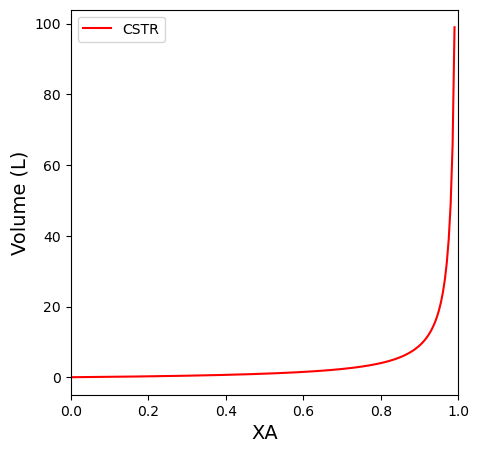

In [3]:
#########################################################################
# Or we can define a function to calculate CSTR volume in Liters        #
# Function is of the form f(XA, α) and returns V                        #
#########################################################################

def VCSTR(XA, α):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = CAf*(1 - XA)
    r   = k*CA**α
    V   = FAf*XA/r
    return V

α_test  = 1.0
XA_test = 0.5
print(f'For α = {α_test:3.1f}: \n XA = {XA_test:4.2f} at VCSTR = {VCSTR(XA_test, α_test):5.3f}L \n')

####################################################################################################
# One advantage of the function is that we can use it to calculate VCSTR at many conversion levels #
####################################################################################################

order    = 1
XAset    = np.linspace(0.001, 0.99, 10)
VCSTRset = VCSTR(XAset, order)

for i,X in enumerate(XAset):
    print(f'A {VCSTRset[i]:5.2f}L CSTR will achieve XA = {X:4.2f}.')


####################################################################################################
# If we can do this, we can also graph V(XA)                                                       #
####################################################################################################

XAfine = np.linspace(0, 0.99, 200)
plt.figure(figsize = (5,5))
plt.plot(XAfine, VCSTR(XAfine, 1), color = 'red', label = 'CSTR')
plt.xlim(0, 1)
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

### A general solution for PFR volume

Next, we recall the solution for PFR volume:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

We can replace the rate law with the generic function of $X_A$ and $\alpha$ as above. We also need to integrate this equation to solve for the PFR volume. Because we have cast the problem as a definite integral, we can do this using Gaussian Quadrature. We'll write a general function that takes the desired conversion and reaction order as arguments and then solves the definite integral to find the corresponding PFR Volume.

In [4]:
######################################################################################
# We can use Python as a calculator...                                               #
######################################################################################

α   = 1
XA  = 0.5
FAf = 1 #mol/min
Qf  = 1 #mol/min
CAf = 1 #mol/L
k   = 1 #1/min
CA  = lambda X: CAf*(1 - X)
r   = lambda X: k*CA(X)**α
int = lambda X: FAf/r(X)
vol, err = quad(int, 0, XA)
print(f'For α = {α:3.1f}: \n XA = {XA:4.2f} at VPFR = {vol:5.3f}L')

For α = 1.0: 
 XA = 0.50 at VPFR = 0.693L


In [5]:
############################################################################################
# Or we can define a function that calculates VPFR for inputs of XA and α                  #
############################################################################################

def VPFR(XA, α):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = lambda X: CAf*(1 - X)
    r   = lambda X: k*CA(X)**α 
    intfun   = lambda X: FAf/r(X)
    vol, err = quad(intfun, 0, XA)
    return vol

α_test  = 1.0
XA_test = 0.5
print(f'For α = {α_test:3.1f}: \n XA = {XA_test:4.2f} at VPFR = {VPFR(XA_test, α_test):5.3f}L')

For α = 1.0: 
 XA = 0.50 at VPFR = 0.693L


In [6]:
##############################################################################################################
# This is a little harder to broadcast; quad cannot operate on an array of integration limits this way       #
##############################################################################################################

order    = 1
XAset    = np.linspace(0.001, 0.99, 10)
# VPFRset  = VPFR(XAset, order)

In [7]:
##############################################################################################################
# We can write a loop to calculate PFR volume for many fractional conversions of A                           #
##############################################################################################################

VPFRtemp = np.zeros(len(XAset))
for i, X in enumerate(XAset):
    VPFRtemp[i] = VPFR(X, order)
    print(f'i = {i:d}, X = {X:4.2f}, V = {VPFRtemp[i]:4.2f}')

i = 0, X = 0.00, V = 0.00
i = 1, X = 0.11, V = 0.12
i = 2, X = 0.22, V = 0.25
i = 3, X = 0.33, V = 0.40
i = 4, X = 0.44, V = 0.58
i = 5, X = 0.55, V = 0.80
i = 6, X = 0.66, V = 1.08
i = 7, X = 0.77, V = 1.47
i = 8, X = 0.88, V = 2.12
i = 9, X = 0.99, V = 4.61


In [8]:
###############################################################################################################
# A list comprehensions offer a convenient shorthand syntax for this type of operation                          #
###############################################################################################################

VPFRset  = [VPFR(val, order) for val in XAset] 
for i,X in enumerate(XAset):
    print(f'A {VPFRset[i]:4.2f}L PFR will achieve XA = {X:4.2f}.')

A 0.00L PFR will achieve XA = 0.00.
A 0.12L PFR will achieve XA = 0.11.
A 0.25L PFR will achieve XA = 0.22.
A 0.40L PFR will achieve XA = 0.33.
A 0.58L PFR will achieve XA = 0.44.
A 0.80L PFR will achieve XA = 0.55.
A 1.08L PFR will achieve XA = 0.66.
A 1.47L PFR will achieve XA = 0.77.
A 2.12L PFR will achieve XA = 0.88.
A 4.61L PFR will achieve XA = 0.99.


### A comparison of CSTR and PFR Volumes for a first order reaction

Now that we have those general functions set up, we will compare results for a few different reaction orders. There are a handful of ways we can do this.  For the CSTR, we'll just pass a numpy array of desired conversions into the VCSTR function. For the PFR, as discussed above, we'll have to use a loop since quadrature won't take an array as an argument (upper limit of integration). For convenience, we will use a list comprehension for this. Again, this is a shorthand for loop that is useful for simple looped operations.

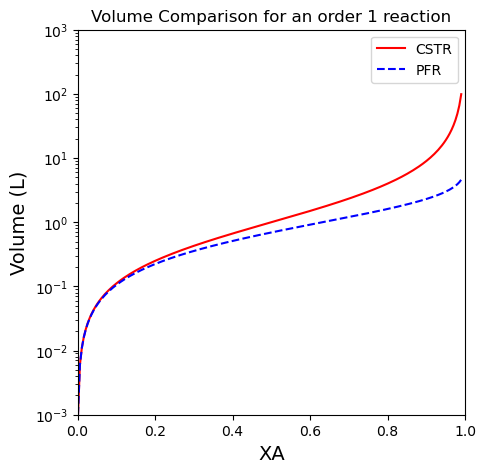

In [9]:
order    = 1
XAset    = np.linspace(0.001, 0.99, 200)
VCSTRset = VCSTR(XAset, order)
VPFRset  = [VPFR(val, order) for val in XAset] 

#Create and format figure
plt.figure(1, figsize = (5,5))
plt.semilogy(XAset, VCSTRset, color = 'red', label = 'CSTR')
plt.semilogy(XAset, VPFRset,  color = 'blue', label = 'PFR', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(1e-3, 1000)
plt.title(f'Volume Comparison for an order {order} reaction')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend()
plt.show()

### A comparison of CSTR and PFR Volumes for a zero order reaction

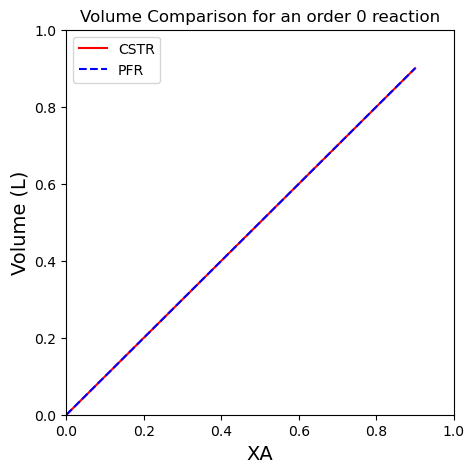

In [10]:
order = 0
XAset = np.linspace(0, 0.9, 100)
VCSTRset = VCSTR(XAset, order)
templist = [VPFR(val, order) for val in XAset] 
VPFRset  = np.array(templist)

#Create and format figure
plt.figure(1, figsize = (5,5))
plt.plot(XAset, VCSTRset, color = 'red', label = 'CSTR')
plt.plot(XAset, VPFRset,  color = 'blue', label = 'PFR', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(f'Volume Comparison for an order {order} reaction')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend()
plt.show()

### A comparison of CSTR and PFR Volumes for a -1 order reaction

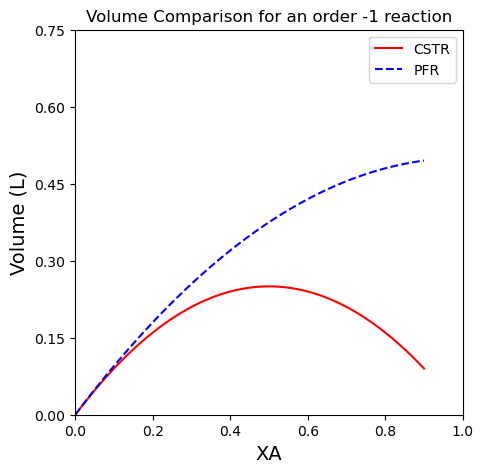

In [11]:
order = -1
XAset = np.linspace(0, 0.9, 100)
VCSTRset = VCSTR(XAset, order)
templist = [VPFR(val, order) for val in XAset] 
VPFRset  = np.array(templist)

#Create and format figure
plt.figure(1, figsize = (5,5))
plt.plot(XAset, VCSTRset, color = 'red', label = 'CSTR')
plt.plot(XAset, VPFRset,  color = 'blue', label = 'PFR', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 0.75)
plt.yticks(np.arange(0.0, 0.76, 0.15))
plt.title(f'Volume Comparison for an order {order} reaction')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend()
plt.show()

### Summarizing Observations

If we review the results obtained so far, we would probably conclude that, for positive order reactions and for achieving conversions greater than 0, the PFR will always be smaller than the CSTR. For negative order reactions, the PFR will always be larger than the CSTR. For zero order reactions, the two reactors will have identical volumes. Now we're going to try to figure out why this happens. A good place to start this discussion is with our generic CSTR and PFR balances that are solved for Volume (in general terms):

**CSTR Volume**

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

**PFR Volume**

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

Looking at those again, we remind ourselves that the size of the reactor will scale directly with the quantity of species A converted and it will scale inversely with the rate at which A is converted.  The numerator term is pretty easy to visualize:

$$F_{A,f}X_A$$

This represents the extensive quantity of species $A$ consumed (in units of moles per time). Since $F_{A,f}$ is constant, this quantity only changes in response to changes in the conversion that we want to achieve in that reactor. As conversion increases, the extensive quantity of species $A$ converted increases.

### Rate as a function of conversion

The denominator is a bit less easy to visualize. To do so, we need to define a rate law.  We will again assume arbitrary power law kinetics and that the rate only depends on the concentration of species A:

$$r(X_A) = k{C_A}^\alpha$$

And as above, we can express the concentration of A in terms of fractional conversion as follows (for a constant density flow reactor):

$$r(X_A) = k{C_{A,f}}^\alpha \, {(1 - X_A)}^\alpha$$

With that, we can define a general rate equation that calculates reaction rate as a function of fractional conversion for any reaction order (in $A$).  See below; once defined we use this function to calculate the rate of reaction for a first order reaction at 50% conversion of A. 

In [12]:
def r(XA, α):
    k   = 1
    CAf = 1
    CA  = CAf*(1 - XA)
    r   = k*CA**α
    return r
print(f'At XA = 0.5 and for a first order reaction, the reaction rate is r(0.5, 1) = {r(0.5, 1):4.2f} mol/L/min')

At XA = 0.5 and for a first order reaction, the reaction rate is r(0.5, 1) = 0.50 mol/L/min


### Visualizing how rate changes as a function of conversion

With this function defined, we can use it with a loop to illustrate how reaction rate changes as a function for various reaction orders. This syntax might look a little strange, but, on each pass, this loop is adding a plot of rate vs. conversion for each reaction order in the set.

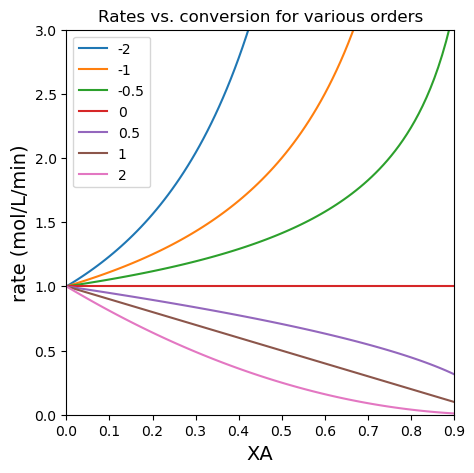

In [13]:
#############################################################################
# Define the set of conversiona and orders to be illustrated here           #
#############################################################################

XAset  = np.linspace(0, 0.9, 100)
orders = [-2, -1, -0.5, 0, 0.5, 1, 2]

#############################################################################
# Create the figure, add plots for each order, set formatting               #
#############################################################################

plt.figure(figsize = (5,5)) 
for order in orders:
    plt.plot(XAset, r(XAset, order), label = str(order))  
plt.title('Rates vs. conversion for various orders')
plt.ylabel('rate (mol/L/min)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,0.9)
plt.ylim(0,3)
plt.legend()
plt.show()

Although we only show a few reaction orders in the plot, the trends are completely general:

1. For $\alpha > 0$, the rate of reaction ***decreases*** with increasing fractional conversion of A (as CA decreases)
2. For $\alpha = 0$, the rate of reaction is ***independent*** of fractional conversion of A
3. For $\alpha < 0$, the rate of reaction ***increases*** with increasing fractional conversion of A (as CA decreases)

### The Levenspiel Plot

Now we'll take a look at the balances for the CSTR and the PFR:

$$V_\textrm{CSTR} = \frac{F_{A,f}}{r \, (X_A)}X_A$$

and

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f}}{r \, (X_A)}dX_A$$

We see that the size of the reactor scales with the ratio of the feed rate of A and the rate of reaction.  Above, we created functions that describe the rate of reaction for various reaction orders. We'll do something similar here and call it a Levenspiel plot.  The quantity of interest for us is the ratio, $F_{A,f}/r \, (X_A)$, so we'll write that in a function and then plot this quantity as a function of fractional conversion.

Specifically:

$$\frac{F_{A,f}}{r \, (X_A)} = \frac{F_{A,f}}{k{C_{A,f}}^\alpha \, (1 - X_A)^\alpha}$$

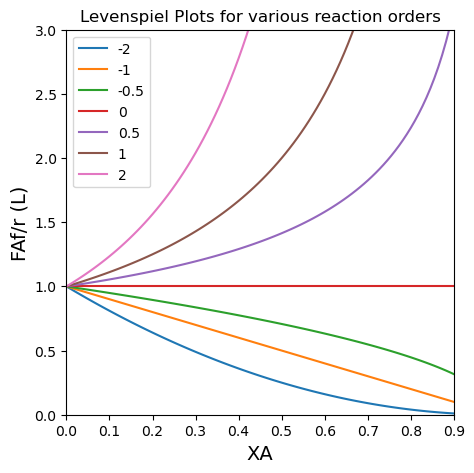

In [14]:
##########################################################################################
# Create a function that calculates the "dependent variable" of a Levenspiel plot, FAf/r #
# rate of reaction invariably depends on both XA and α, so we pass both as arguments     #
##########################################################################################

def LEV(XA, α):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    CA  = CAf*(1 - XA)
    r   = k*CA**α
    return FAf/r

##########################################################################################
# Now we define a set of conversions over which we want to plot LEV                      #
##########################################################################################

XAset = np.linspace(0, 0.9, 100)

##########################################################################################
# Now we create the figure, overlay results for various orders, and format               #
##########################################################################################

plt.figure(figsize = (5,5))
for order in [-2, -1, -0.5, 0, 0.5, 1, 2]:
    plt.plot(XAset, LEV(XAset, order), label = str(order))
plt.title('Levenspiel Plots for various reaction orders')
plt.ylabel('FAf/r (L)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,0.9)
plt.ylim(0,3)
plt.legend()
plt.show()

The figure above is basically showing you how inverse rate changes as a function of fractional conversion.  

1. For positive order kinetics, inverse rate gets larger as $X_A$ increases.  
2. For negative order kinetics, inverse rate gets smaller as $X_A$ increases.  
3. For zero order kinetics, inverse rate is constant as $X_A$ varies. 

To use the plots and to start understanding the trends, we'll focus on the first order case. Before we do, let's recall some results for CSTR and PFR volumes required to achieve specific conversions for the case of first order kinetics. As benchmarks, we'll print out the CSTR and PFR volumes required to achieve conversions of $X_A = [0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9]$.

In [15]:
XAtest = [0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9]
VCtest = [VCSTR(val, 1) for val in XAtest] #We can use a list comprehension to calculate CSTR volumes here; this is a shorthand for loop
VPtest = [VPFR(val, 1) for val in XAtest]  #This is another list comprehension to calculate PFR volumes.

for XA, VC, VP in zip(XAtest, VCtest, VPtest):  #zip is handy; it let's you iterate over values in multiple sets.
    if XA == 0.05:
        print('For a first order reaction with the specified parameters...')
    print(f'To achieve a conversion of {XA:3.2f}, the CSTR volume is {VC:3.3f}L and the PFR volume is {VP:3.3f}L')

For a first order reaction with the specified parameters...
To achieve a conversion of 0.05, the CSTR volume is 0.053L and the PFR volume is 0.051L
To achieve a conversion of 0.10, the CSTR volume is 0.111L and the PFR volume is 0.105L
To achieve a conversion of 0.20, the CSTR volume is 0.250L and the PFR volume is 0.223L
To achieve a conversion of 0.30, the CSTR volume is 0.429L and the PFR volume is 0.357L
To achieve a conversion of 0.50, the CSTR volume is 1.000L and the PFR volume is 0.693L
To achieve a conversion of 0.75, the CSTR volume is 3.000L and the PFR volume is 1.386L
To achieve a conversion of 0.90, the CSTR volume is 9.000L and the PFR volume is 2.303L


Now that we have specific volumes in mind for these various cases, we can proceed with the Levenspiel Plot analysis.  We'll go back again to the balances on the CSTR and PFR that we have solved for volume. We will look at the CSTR result first.

$$V_\textrm{CSTR} = \frac{F_{A,f}}{r \, (X_A)}X_A$$

We should be able to see that the volume of the CSTR is obtained by multiplying the dependent variable ("y") from our "LEV" function, $F_{A,f}/r \, (X_A)$ and the independent variable of fractional conversion achieved in that reactor. Since we assume a CSTR is perfectly mixed, the relevant reaction rate is specified at the exit composition (exit conversion). The entire volume of a CSTR is therefore operating at an identical conversion value to the exit stream because it is perfectly mixed. That means the rate of reaction in a CSTR is uniform throughout, and that the rate of reaction is **calculated at the exit conditions of the CSTR**.  In a graphical context, if we plot our "LEV" function against fractional conversion, then the volume of a CSTR is given by the product of the "LEV" function value at a specific conversion (i.e., the "y" axis on our plot) and the value of fractional conversion at the reactor exit (i.e., the "x" axis on our plot). Ultimately, the CSTR volume on a Levenspiel plot looks like a rectangle whose upper right vertex is defined by the exit conditions on the Levenspiel plot (see figures below).

Next, we consider the analogous result obtained for the volume of a PFR:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f}}{r \, (X_A)}dX_A$$

In the PFR, we see that the right hand side involves the product of our "LEV" function, $F_{A,f}/r \, (X_A)$ and a differential change in fractional conversion. To determine the PFR volume, we have to evaluate the integral on the right hand side. Specifically, integrate our "LEV" function, $F_{A,f}/r \, (X_A)$, as a function of fractional conversion from zero conversion to the exit conversion. This allows us to account for the way a PFR operates, which is to incrementally increase conversion from inlet to exit through a series of axial slices.  In a graphical context, the volume of the PFR represents the area under the curve in a Levenspiel plot.

#### Results for a first order reaction

The preceding discussions seem abstract until you see the results for CSTR volume and PFR volume illustrated on a Levenspiel plot. We generate this plot by graphing "LEV" function vs. fractional conversion. For now, we will only do so for a first order reaction.

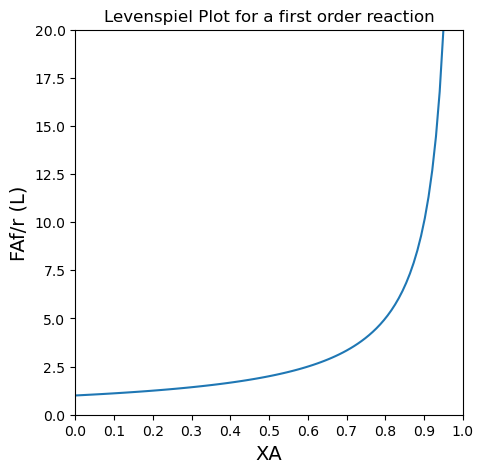

In [16]:
XAset = np.linspace(0, 0.95, 100)
plt.figure(1, figsize = (5,5))
plt.plot(XAset, LEV(XAset, 1))
plt.title('Levenspiel Plot for a first order reaction')
plt.ylabel('FAf/r (L)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show(1)

Next we will add a bit of detail to that plot. Specifically, we'll add a vertical line at XA = 0.9, and we'll add a horizontal line at the corresponding value of FAf/r. This will bound the rectangle that defines the CSTR volume.

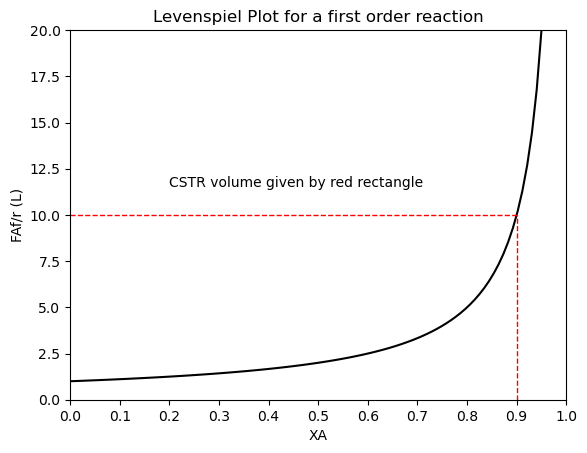

In [17]:
XAset = np.linspace(0, 0.95, 100)
plt.plot(XAset, LEV(XAset, 1), color = 'black')
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, 1), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red rectangle', (0.2, 11.5))
plt.title('Levenspiel Plot for a first order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

The volume of the CSTR is given by the product of FAf/r and XA at the exit.  Here, we see those numbers are 10L and 0.9.  Multiply them together, and we get the CSTR volume is 9.0L just as we did in the analytical solution. In contrast, if we wanted to get the PFR volume, we'd need to take the integral of FAf/r from XA = 0 to XA = 0.9, i.e., we would have to find the area under the curve shown in the figure above.  We'll add that illustration to show the PFR volume on the Levenspiel plot.

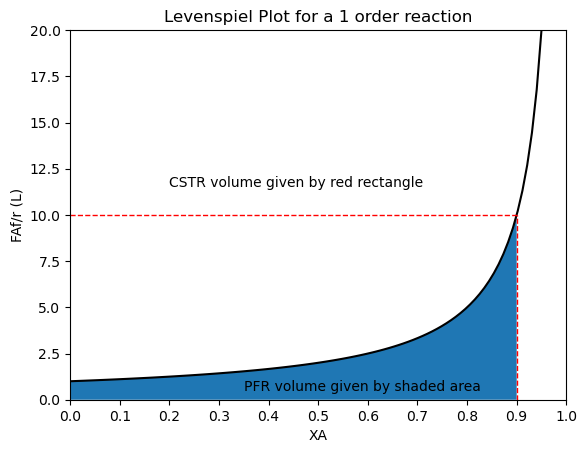

In [18]:
order = 1
XAset = np.linspace(0, 0.95, 100)
XAPFR = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))
plt.vlines(0.9, 0, LEV(0.9, order), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red rectangle', (0.2, 11.5))
plt.annotate('PFR volume given by shaded area', (0.35, 0.5))
plt.title(f'Levenspiel Plot for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

There are a lot of ways to do the integral, but since we have a function for the Levenspiel plot, using Gaussian Quadrature to integrate it is sensible. Doing so, we find that the PFR volume here is 2.3 liters, just as above:

In [19]:
integrand      = lambda x: LEV(x, 1)
VPFR_quad, err = quad(integrand, 0, 0.9)
print(f'A {VPFR_quad:5.3f}L PFR will achieve a conversion of XA = 0.9.')

A 2.303L PFR will achieve a conversion of XA = 0.9.


#### Results for a zero order reaction

Next, we compare CSTR and PFR sizes for a zero order reaction.

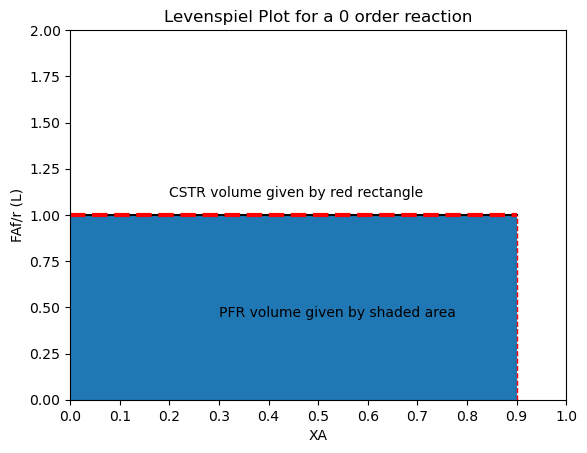

In [20]:
order = 0
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAset, LEV(XAset, order))
plt.vlines(0.9, 0, LEV(0.9, order), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 3)
plt.annotate('CSTR volume given by red rectangle', (0.2, 1.1))
plt.annotate('PFR volume given by shaded area', (0.3, 0.45))
plt.title(f'Levenspiel Plot for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, 2*ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

#### Results for -1 order reaction

Now we compare CSTR and PFR sizes for a -1 order reaction

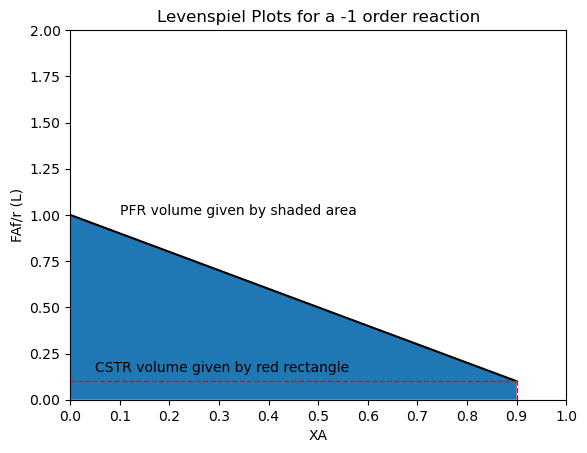

In [21]:
order = -1
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAset, LEV(XAset, order))
plt.vlines(0.9, 0, LEV(0.9, order), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red rectangle', (0.05, 0.15))
plt.annotate('PFR volume given by shaded area', (0.1, 1.0))
plt.title(f'Levenspiel Plots for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, 2*ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

#### Explanation and Rationale

The **reason** that we observe these differences has to do with the fundamental difference in the way that PFRs and CSTRs and CSTRs operate. With a PFR, the conversion (and concentration) change gradually as we go from the inlet of the reactor to the exit of the reactor.  The PFR begins operation at a relatively high concentration of $A$ at the inlet, and it gradually approaches a relatively low concentration of $A$ at the exit. So, in a PFR, the rate of reaction incrementally changes as one moves down the length of the PFR accumulating volume and residence time.  

For a positive order reaction, the rate *decreases* down the length of the PFR. For a zero order reaction, the rate is *constant* down the length of the PFR. For a negative order reaction, the rate *increases* down the length of the PFR. In all cases, we have to average these effects by integrating with respect to the differential changes in volume that occur as we move from one axial slice to the next down the length of the PFR.

A CSTR is the exact opposite. As soon as the feed enters the CSTR, it is instantly mixed, and the inside of the CSTR all exists as the same conditions as at the CSTR exit. For this reason, the concentration everywhere inside the CSTR is exactly the same as it is in the exit conditions. At the exit conditions, we generally have a relatively high fractional conversion of $A$ and a correspondingly low concentration of reactant $A$. As a result, the CSTR always operates at the lowest value of concentration possible in the system of interest. For a positive order reaction, this means that the rate in the CSTR is as small as it can possibly be (lowest CA). For a zero order reaction, the rate is independent of conversion/concentration, so operating at a conversion of 90% gives you the same rate you'd see at a conversion of 0%. For negative order reaction, rate increases with conversion, so the CSTR operates at minimum concentration of A, which gives a maximum reaction rate!

For a positive order reaction, on average, the PFR will always have the higher rate across the reactor volume--it starts at a high rate and finishes at the minimum rate.  The CSTR operates entirely at the minimum rate, so it's average reaction rate is always lower for a positive order reaction. The converse is true for a negative order reaction--the rate will gradually increase down the length of the PFR, whereas the CSTR operates entirely at the exit conversion and thus the maximum rate.  For a zero order reaction, rate is independent of conversion, and PFRs and CSTRs will have the same average rate.

Since the size of a system is determined by the ratio of the "stuff" that gets converted to the rate at which it gets converted, it is easy to predict PFR and CSTR sizing trends once we grasp the above concepts. PFRs will always be smaller for positive order reactions because, on average, they have a higher reaction rate than a CSTR achieving the same conversion. In contrast, for negative order reactions, PFRs will always be larger because, on average, they have a lower reaction rate than a CSTR achieving the same conversion. For zero order reactions, they will be the exact same size because the rates are equal in the two systems.